In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# raw_dataset = pd.read_csv("/data/fast0/datasets/glathida-3.1.0/data/T.csv")
# raw_dataset = pd.read_csv("~/notebooks/glac/data/TTT.csv")
raw_dataset = pd.read_csv("~/stuff/coding/glacier/glac/data/T.csv")

dataset = raw_dataset.copy()

#examine missing data
# dataset.head()

2.6.0


In [2]:
#drop everything but lat, long, elevation, thickness

dataset = dataset.drop("GlaThiDa_ID", axis=1)
dataset = dataset.drop("GLACIER_DB", axis=1)
dataset = dataset.drop("POLITICAL_UNIT", axis=1)
dataset = dataset.drop("GLACIER_ID", axis=1)
dataset = dataset.drop("GLACIER_NAME", axis=1)
dataset = dataset.drop("SURVEY_DATE", axis=1)
dataset = dataset.drop("MEAN_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("MAXIMUM_THICKNESS", axis=1)
dataset = dataset.drop("MAX_THICKNESS_UNCERTAINTY", axis=1)
dataset = dataset.drop("DATA_FLAG", axis=1)
dataset = dataset.drop("ELEVATION_DATE", axis=1)
dataset = dataset.drop("SPONSORING_AGENCY", axis=1)
dataset = dataset.drop("REMARKS", axis=1)
dataset = dataset.drop("SURVEY_METHOD_DETAILS", axis=1)
dataset = dataset.drop("SURVEY_METHOD", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_POINTS", axis=1)
dataset = dataset.drop("NUMBER_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("TOTAL_LENGTH_OF_SURVEY_PROFILES", axis=1)
dataset = dataset.drop("INTERPOLATION_METHOD", axis=1)
dataset = dataset.drop("INVESTIGATOR", axis=1)
dataset = dataset.drop("REFERENCES", axis=1)

#sum up rows with empty cells
dataset.isna().sum()

#drop the remaining null pieces from elevation
dataset = dataset.dropna()
dataset.isna().sum()

LAT               0
LON               0
AREA              0
MEAN_SLOPE        0
MEAN_THICKNESS    0
dtype: int64

In [3]:
dataset

,LAT,LON,AREA,MEAN_SLOPE,MEAN_THICKNESS
32,48.750000,-121.830000,2.900,0.0,58.0
33,58.380000,-134.360000,11.700,0.0,66.0
34,50.061340,87.697410,5.150,0.0,56.0
35,50.049670,87.745520,2.840,0.0,86.0
36,50.080080,87.690250,5.950,0.0,90.0
...,...,...,...,...,...
620,78.245480,16.064380,2.100,13.0,32.0
628,43.043653,77.080587,2.610,20.0,47.0
632,77.971400,14.069100,6.737,6.0,65.0
749,77.027200,15.485400,0.370,19.0,27.0


# 

In [4]:
#split the dataset and reserve some to test what was trained.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

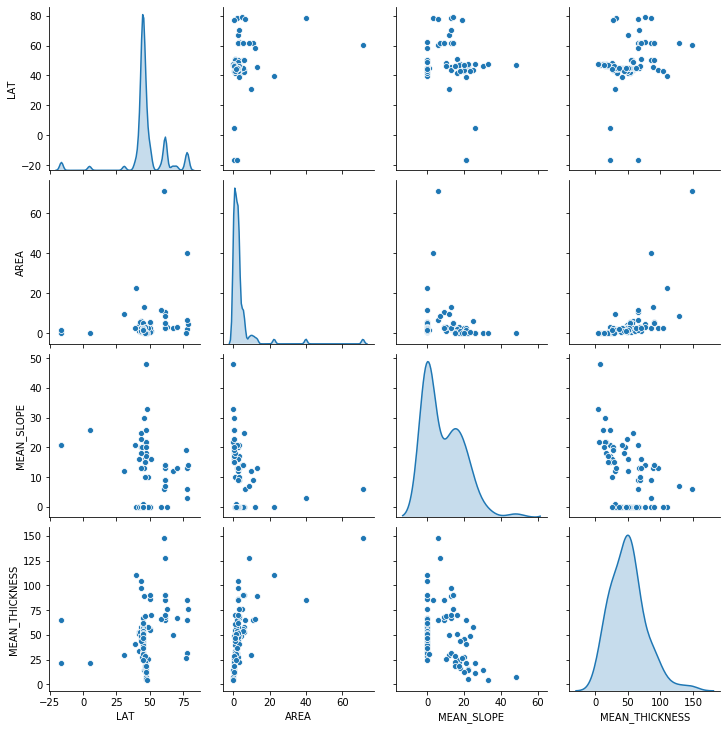

In [5]:
sns.pairplot(train_dataset[["LAT", "AREA", "MEAN_SLOPE", "MEAN_THICKNESS"]], diag_kind='kde')

In [6]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LAT,89.0,47.465341,14.458029,-16.3023,44.584600,45.080000,48.75000,78.87100
LON,89.0,41.704321,55.546192,-134.3600,8.602228,78.176022,79.82588,140.86536
AREA,89.0,4.060882,8.853776,0.0264,1.000000,2.100000,3.22750,71.30000
MEAN_SLOPE,89.0,8.797753,10.230502,0.0000,0.000000,6.000000,16.00000,48.00000
MEAN_THICKNESS,89.0,50.460674,27.011806,4.0000,30.000000,49.000000,65.00000,148.00000


In [7]:
#separate out features - what will be trained to predict desired attribute
train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop("MEAN_THICKNESS")
test_labels = test_features.pop("MEAN_THICKNESS")

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LAT,47.465341,14.458029
LON,41.704321,55.546192
AREA,4.060882,8.853776
MEAN_SLOPE,8.797753,10.230502


# Establish normalization layers

In [44]:
#build normalizer layers for each model to be run

normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

area = np.array(train_features["AREA"])
area_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
area_normalizer.adapt(area)

lat = np.array(train_features["LAT"])
lat_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lat_normalizer.adapt(lat)

lon = np.array(train_features["LON"])
lon_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
lon_normalizer.adapt(lon)

slope = np.array(train_features["MEAN_SLOPE"])
slope_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
slope_normalizer.adapt(slope)

# build model function to call

In [47]:
# #how to condense model into callable function with fillable variables? even possible?
# 88_model = tf.keras.Sequential([
#     88_normalizer,
#     layers.Dense(1)
# ])


# 88_model.compile(
#     optimizer=tf.optimizers.Adam(learning_rate=0.1),
#     loss="mean_absolute_error")

# %%time
# history_88 = 88_model.fit(
#     train_features["*^*"], train_labels,
#     epochs=400,
#     # suppress logging
#     verbose=0,
#     # Calculate validation results on 20% of the training data
#     validation_split = 0.2)

# test_results = {}
# test_results["*_model"] = area_model.evaluate(
#     test_features["*^*"],
#     test_labels, verbose=0)

# test_results

# def plot_area(x, y):
#     plt.scatter(train_features["*^*"], train_labels, label='Data')
#     plt.plot(x, y, color='k', label='Predictions')
#     plt.xlabel('Area (km**2)')
#     plt.ylabel('Thickness')
#     plt.xlim((0,20))
#     plt.legend()
    
# x = tf.linspace(0.0, 20, 101)
# y = area_model.predict(x)
# plot_area(x,y)

# def plot_loss(history_area):
#   plt.plot(history_area.history['loss'], label='loss')
#   plt.plot(history_area.history['val_loss'], label='val_loss')
# #   plt.ylim([0, 10])
#   plt.xlabel('Epoch')
#   plt.ylabel('Error [MPG]')
#   plt.legend()
#   plt.grid(True)
# plot_loss(history_area)



SyntaxError: invalid token (<ipython-input-47-df63142ad6a5>, line 4)

# Linear regression with area

In [102]:
#build elevation model with Sequential
area_model = tf.keras.Sequential([
    area_normalizer,
    layers.Dense(1)
])

area_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.6),
    loss="mean_absolute_error")

history_area = area_model.fit(
    train_features["AREA"], train_labels,
    epochs=1000,
    verbose=0,
    validation_split = 0.2)

test_results = {}
test_results['area_model'] = area_model.evaluate(
    test_features['AREA'],
    test_labels, verbose=0)

test_results

{'area_model': 75.30238342285156}

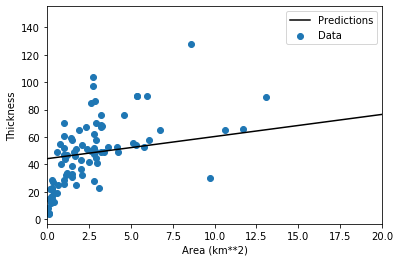

In [103]:
def plot_area(x, y):
    plt.scatter(train_features['AREA'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Area (km**2)')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_area(x,y)

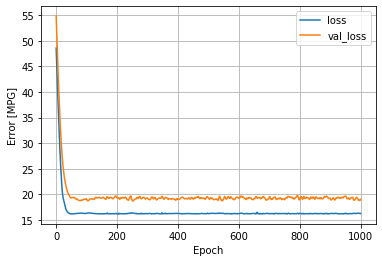

In [104]:
def plot_loss(history_area):
  plt.plot(history_area.history['loss'], label='loss')
  plt.plot(history_area.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history_area)


# Linear regression with latitude

In [68]:
#build elevation model with Sequential
lat_model = tf.keras.Sequential([
    lat_normalizer,
    layers.Dense(1)
])

lat_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

history_lat = lat_model.fit(
    train_features["LAT"], train_labels,
    epochs=400,
    verbose=0,
    validation_split = 0.2)

test_results["lat_model"] = area_model.evaluate(
    test_features["LAT"],
    test_labels, verbose=0)

test_results

{'area_model': 69.46585083007812, 'lat_model': 76.9737319946289}

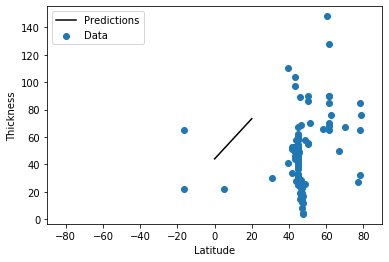

In [69]:
def plot_latitude(x, y):
    plt.scatter(train_features["LAT"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel("Latitude")
    plt.ylabel('Thickness')
    plt.xlim((-90,90))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_latitude(x,y)

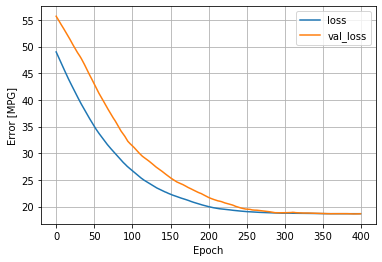

In [70]:
plot_loss(history_lat)

# Linear regression with longitude

In [71]:
lon_model = tf.keras.Sequential([
    lon_normalizer,
    layers.Dense(1)
])

lon_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

history_lon = lon_model.fit(
    train_features["LON"], train_labels,
    epochs=400,
    verbose=0,
    validation_split = 0.2)

test_results["lon_model"] = area_model.evaluate(
    test_features["LON"],
    test_labels, verbose=0)

test_results

{'area_model': 69.46585083007812,
 'lat_model': 76.9737319946289,
 'lon_model': 86.64031982421875}

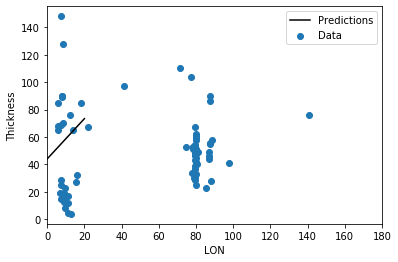

In [72]:
def plot_longitude(x, y):
    plt.scatter(train_features["LON"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('LON')
    plt.ylabel('Thickness')
    plt.xlim((0,180))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = area_model.predict(x)
plot_longitude(x,y)

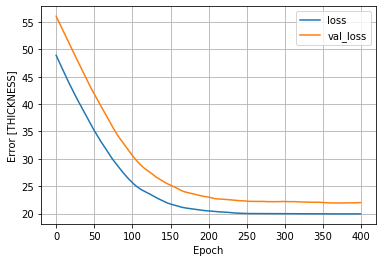

In [74]:
plot_loss(history_lon)

# Multiple inputs

In [28]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
multi_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [29]:
multi_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

In [30]:
%%time
history_multi = multi_model.fit(
    train_features, train_labels, 
    epochs=1000,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 15.7 s, sys: 736 ms, total: 16.4 s
Wall time: 14.7 s


In [31]:
#not sure what exactly is going on here but I'm sure this is what needs tweaking
test_results["multi_model"] = multi_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

{'area_model': 69.38870239257812,
 'lat_model': 27.6687068939209,
 'lon_model': 29.304780960083008,
 'multi_model': 45.14334487915039}

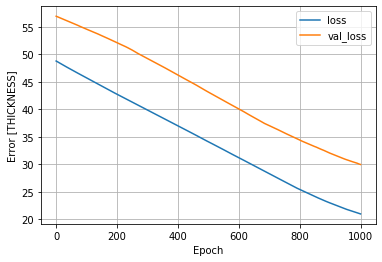

In [32]:
plot_loss(history_multi)

# DNN regression

### Single variable

In [33]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0001))
  return model

In [34]:
dnn_area_model = build_and_compile_model(area_normalizer)

In [35]:
dnn_area_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [36]:
%%time
history_dnn = dnn_area_model.fit(
    train_features["AREA"], train_labels,
    validation_split=0.2,
    #verbose=0,
    epochs=1500)

Epoch 1/1500
3/3 [==============================] - 0s 107ms/step - loss: 48.8438 - val_loss: 56.4407
Epoch 2/1500
3/3 [==============================] - 0s 10ms/step - loss: 48.8376 - val_loss: 56.4353
Epoch 3/1500
3/3 [==============================] - 0s 16ms/step - loss: 48.8307 - val_loss: 56.4300
Epoch 4/1500
3/3 [==============================] - 0s 14ms/step - loss: 48.8244 - val_loss: 56.4249
Epoch 5/1500
3/3 [==============================] - 0s 15ms/step - loss: 48.8183 - val_loss: 56.4197
Epoch 6/1500
3/3 [==============================] - 0s 15ms/step - loss: 48.8118 - val_loss: 56.4146
Epoch 7/1500
3/3 [==============================] - 0s 12ms/step - loss: 48.8060 - val_loss: 56.4095
Epoch 8/1500
3/3 [==============================] - 0s 14ms/step - loss: 48.7995 - val_loss: 56.4044
Epoch 9/1500
3/3 [==============================] - 0s 15ms/step - loss: 48.7931 - val_loss: 56.3994
Epoch 10/1500
3/3 [==============================] - 0s 16ms/step - loss: 48.7869 - val_lo

3/3 [==============================] - 0s 11ms/step - loss: 48.0072 - val_loss: 55.7156
Epoch 82/1500
3/3 [==============================] - 0s 11ms/step - loss: 47.9889 - val_loss: 55.6993
Epoch 83/1500
3/3 [==============================] - 0s 11ms/step - loss: 47.9702 - val_loss: 55.6827
Epoch 84/1500
3/3 [==============================] - 0s 10ms/step - loss: 47.9519 - val_loss: 55.6657
Epoch 85/1500
3/3 [==============================] - 0s 11ms/step - loss: 47.9315 - val_loss: 55.6486
Epoch 86/1500
3/3 [==============================] - 0s 11ms/step - loss: 47.9118 - val_loss: 55.6311
Epoch 87/1500
3/3 [==============================] - 0s 12ms/step - loss: 47.8920 - val_loss: 55.6136
Epoch 88/1500
3/3 [==============================] - 0s 11ms/step - loss: 47.8724 - val_loss: 55.5958
Epoch 89/1500
3/3 [==============================] - 0s 15ms/step - loss: 47.8523 - val_loss: 55.5778
Epoch 90/1500
3/3 [==============================] - 0s 10ms/step - loss: 47.8323 - val_loss: 55

Epoch 161/1500
3/3 [==============================] - 0s 12ms/step - loss: 45.5358 - val_loss: 53.4513
Epoch 162/1500
3/3 [==============================] - 0s 12ms/step - loss: 45.4883 - val_loss: 53.4083
Epoch 163/1500
3/3 [==============================] - 0s 11ms/step - loss: 45.4429 - val_loss: 53.3648
Epoch 164/1500
3/3 [==============================] - 0s 11ms/step - loss: 45.3942 - val_loss: 53.3207
Epoch 165/1500
3/3 [==============================] - 0s 11ms/step - loss: 45.3474 - val_loss: 53.2759
Epoch 166/1500
3/3 [==============================] - 0s 10ms/step - loss: 45.2988 - val_loss: 53.2309
Epoch 167/1500
3/3 [==============================] - 0s 10ms/step - loss: 45.2521 - val_loss: 53.1860
Epoch 168/1500
3/3 [==============================] - 0s 11ms/step - loss: 45.2053 - val_loss: 53.1417
Epoch 169/1500
3/3 [==============================] - 0s 12ms/step - loss: 45.1579 - val_loss: 53.0979
Epoch 170/1500
3/3 [==============================] - 0s 12ms/step - loss

3/3 [==============================] - 0s 19ms/step - loss: 40.8794 - val_loss: 48.8123
Epoch 241/1500
3/3 [==============================] - 0s 23ms/step - loss: 40.8066 - val_loss: 48.7355
Epoch 242/1500
3/3 [==============================] - 0s 16ms/step - loss: 40.7306 - val_loss: 48.6583
Epoch 243/1500
3/3 [==============================] - 0s 20ms/step - loss: 40.6562 - val_loss: 48.5793
Epoch 244/1500
3/3 [==============================] - 0s 16ms/step - loss: 40.5816 - val_loss: 48.4988
Epoch 245/1500
3/3 [==============================] - 0s 10ms/step - loss: 40.5032 - val_loss: 48.4177
Epoch 246/1500
3/3 [==============================] - 0s 18ms/step - loss: 40.4245 - val_loss: 48.3362
Epoch 247/1500
3/3 [==============================] - 0s 10ms/step - loss: 40.3451 - val_loss: 48.2546
Epoch 248/1500
3/3 [==============================] - 0s 13ms/step - loss: 40.2674 - val_loss: 48.1712
Epoch 249/1500
3/3 [==============================] - 0s 11ms/step - loss: 40.1858 - val

3/3 [==============================] - 0s 11ms/step - loss: 33.6390 - val_loss: 41.4194
Epoch 320/1500
3/3 [==============================] - 0s 12ms/step - loss: 33.5478 - val_loss: 41.3212
Epoch 321/1500
3/3 [==============================] - 0s 11ms/step - loss: 33.4553 - val_loss: 41.2207
Epoch 322/1500
3/3 [==============================] - 0s 11ms/step - loss: 33.3599 - val_loss: 41.1200
Epoch 323/1500
3/3 [==============================] - 0s 11ms/step - loss: 33.2663 - val_loss: 41.0169
Epoch 324/1500
3/3 [==============================] - 0s 10ms/step - loss: 33.1718 - val_loss: 40.9128
Epoch 325/1500
3/3 [==============================] - 0s 11ms/step - loss: 33.0714 - val_loss: 40.8083
Epoch 326/1500
3/3 [==============================] - 0s 12ms/step - loss: 32.9739 - val_loss: 40.7002
Epoch 327/1500
3/3 [==============================] - 0s 10ms/step - loss: 32.8777 - val_loss: 40.5906
Epoch 328/1500
3/3 [==============================] - 0s 11ms/step - loss: 32.7701 - val

3/3 [==============================] - 0s 11ms/step - loss: 26.8719 - val_loss: 33.3747
Epoch 399/1500
3/3 [==============================] - 0s 12ms/step - loss: 26.7937 - val_loss: 33.2955
Epoch 400/1500
3/3 [==============================] - 0s 12ms/step - loss: 26.7201 - val_loss: 33.2176
Epoch 401/1500
3/3 [==============================] - 0s 10ms/step - loss: 26.6533 - val_loss: 33.1406
Epoch 402/1500
3/3 [==============================] - 0s 11ms/step - loss: 26.5760 - val_loss: 33.0628
Epoch 403/1500
3/3 [==============================] - 0s 11ms/step - loss: 26.5077 - val_loss: 32.9837
Epoch 404/1500
3/3 [==============================] - 0s 10ms/step - loss: 26.4263 - val_loss: 32.9072
Epoch 405/1500
3/3 [==============================] - 0s 10ms/step - loss: 26.3630 - val_loss: 32.8258
Epoch 406/1500
3/3 [==============================] - 0s 11ms/step - loss: 26.2797 - val_loss: 32.7478
Epoch 407/1500
3/3 [==============================] - 0s 11ms/step - loss: 26.2067 - val

3/3 [==============================] - 0s 10ms/step - loss: 21.4776 - val_loss: 27.9440
Epoch 478/1500
3/3 [==============================] - 0s 19ms/step - loss: 21.4231 - val_loss: 27.8899
Epoch 479/1500
3/3 [==============================] - 0s 14ms/step - loss: 21.3795 - val_loss: 27.8372
Epoch 480/1500
3/3 [==============================] - 0s 12ms/step - loss: 21.3313 - val_loss: 27.7829
Epoch 481/1500
3/3 [==============================] - 0s 9ms/step - loss: 21.2839 - val_loss: 27.7233
Epoch 482/1500
3/3 [==============================] - 0s 11ms/step - loss: 21.2314 - val_loss: 27.6663
Epoch 483/1500
3/3 [==============================] - 0s 11ms/step - loss: 21.1848 - val_loss: 27.6091
Epoch 484/1500
3/3 [==============================] - 0s 11ms/step - loss: 21.1364 - val_loss: 27.5561
Epoch 485/1500
3/3 [==============================] - 0s 10ms/step - loss: 21.0971 - val_loss: 27.5076
Epoch 486/1500
3/3 [==============================] - 0s 11ms/step - loss: 21.0631 - val_

3/3 [==============================] - 0s 11ms/step - loss: 19.7830 - val_loss: 25.0690
Epoch 557/1500
3/3 [==============================] - 0s 10ms/step - loss: 19.7676 - val_loss: 25.0358
Epoch 558/1500
3/3 [==============================] - 0s 10ms/step - loss: 19.7504 - val_loss: 24.9971
Epoch 559/1500
3/3 [==============================] - 0s 11ms/step - loss: 19.7318 - val_loss: 24.9592
Epoch 560/1500
3/3 [==============================] - 0s 12ms/step - loss: 19.7180 - val_loss: 24.9210
Epoch 561/1500
3/3 [==============================] - 0s 12ms/step - loss: 19.7015 - val_loss: 24.8850
Epoch 562/1500
3/3 [==============================] - 0s 10ms/step - loss: 19.6851 - val_loss: 24.8511
Epoch 563/1500
3/3 [==============================] - 0s 11ms/step - loss: 19.6730 - val_loss: 24.8210
Epoch 564/1500
3/3 [==============================] - 0s 11ms/step - loss: 19.6552 - val_loss: 24.7989
Epoch 565/1500
3/3 [==============================] - 0s 11ms/step - loss: 19.6435 - val

3/3 [==============================] - 0s 16ms/step - loss: 18.8564 - val_loss: 22.9360
Epoch 636/1500
3/3 [==============================] - 0s 16ms/step - loss: 18.8463 - val_loss: 22.9113
Epoch 637/1500
3/3 [==============================] - 0s 12ms/step - loss: 18.8397 - val_loss: 22.8813
Epoch 638/1500
3/3 [==============================] - 0s 15ms/step - loss: 18.8312 - val_loss: 22.8541
Epoch 639/1500
3/3 [==============================] - 0s 14ms/step - loss: 18.8207 - val_loss: 22.8366
Epoch 640/1500
3/3 [==============================] - 0s 18ms/step - loss: 18.8133 - val_loss: 22.8177
Epoch 641/1500
3/3 [==============================] - 0s 19ms/step - loss: 18.8055 - val_loss: 22.8002
Epoch 642/1500
3/3 [==============================] - 0s 22ms/step - loss: 18.7972 - val_loss: 22.7846
Epoch 643/1500
3/3 [==============================] - 0s 19ms/step - loss: 18.7890 - val_loss: 22.7718
Epoch 644/1500
3/3 [==============================] - 0s 22ms/step - loss: 18.7811 - val

3/3 [==============================] - 0s 11ms/step - loss: 18.3211 - val_loss: 21.8752
Epoch 715/1500
3/3 [==============================] - 0s 13ms/step - loss: 18.3147 - val_loss: 21.8648
Epoch 716/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.3104 - val_loss: 21.8544
Epoch 717/1500
3/3 [==============================] - 0s 11ms/step - loss: 18.3038 - val_loss: 21.8462
Epoch 718/1500
3/3 [==============================] - 0s 11ms/step - loss: 18.2986 - val_loss: 21.8317
Epoch 719/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.2923 - val_loss: 21.8175
Epoch 720/1500
3/3 [==============================] - 0s 12ms/step - loss: 18.2867 - val_loss: 21.8059
Epoch 721/1500
3/3 [==============================] - 0s 10ms/step - loss: 18.2806 - val_loss: 21.7958
Epoch 722/1500
3/3 [==============================] - 0s 11ms/step - loss: 18.2747 - val_loss: 21.7839
Epoch 723/1500
3/3 [==============================] - 0s 11ms/step - loss: 18.2699 - val

3/3 [==============================] - 0s 11ms/step - loss: 17.9118 - val_loss: 21.0517
Epoch 794/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.9054 - val_loss: 21.0430
Epoch 795/1500
3/3 [==============================] - 0s 12ms/step - loss: 17.9011 - val_loss: 21.0318
Epoch 796/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.8961 - val_loss: 21.0191
Epoch 797/1500
3/3 [==============================] - 0s 12ms/step - loss: 17.8922 - val_loss: 21.0077
Epoch 798/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.8868 - val_loss: 21.0030
Epoch 799/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.8816 - val_loss: 20.9943
Epoch 800/1500
3/3 [==============================] - 0s 13ms/step - loss: 17.8765 - val_loss: 20.9847
Epoch 801/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.8736 - val_loss: 20.9681
Epoch 802/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.8655 - val

3/3 [==============================] - 0s 11ms/step - loss: 17.5550 - val_loss: 20.3672
Epoch 873/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.5553 - val_loss: 20.3566
Epoch 874/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.5515 - val_loss: 20.3490
Epoch 875/1500
3/3 [==============================] - 0s 12ms/step - loss: 17.5480 - val_loss: 20.3424
Epoch 876/1500
3/3 [==============================] - 0s 13ms/step - loss: 17.5442 - val_loss: 20.3376
Epoch 877/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.5403 - val_loss: 20.3350
Epoch 878/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.5368 - val_loss: 20.3309
Epoch 879/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.5323 - val_loss: 20.3235
Epoch 880/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.5300 - val_loss: 20.3173
Epoch 881/1500
3/3 [==============================] - 0s 12ms/step - loss: 17.5261 - val

3/3 [==============================] - 0s 11ms/step - loss: 17.3138 - val_loss: 20.2024
Epoch 952/1500
3/3 [==============================] - 0s 15ms/step - loss: 17.3102 - val_loss: 20.1920
Epoch 953/1500
3/3 [==============================] - 0s 14ms/step - loss: 17.3067 - val_loss: 20.1864
Epoch 954/1500
3/3 [==============================] - 0s 19ms/step - loss: 17.3034 - val_loss: 20.1777
Epoch 955/1500
3/3 [==============================] - 0s 18ms/step - loss: 17.3016 - val_loss: 20.1650
Epoch 956/1500
3/3 [==============================] - 0s 18ms/step - loss: 17.2988 - val_loss: 20.1591
Epoch 957/1500
3/3 [==============================] - 0s 15ms/step - loss: 17.2957 - val_loss: 20.1571
Epoch 958/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.2946 - val_loss: 20.1605
Epoch 959/1500
3/3 [==============================] - 0s 13ms/step - loss: 17.2896 - val_loss: 20.1611
Epoch 960/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.2869 - val

3/3 [==============================] - 0s 10ms/step - loss: 17.1025 - val_loss: 19.9996
Epoch 1031/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.1012 - val_loss: 19.9985
Epoch 1032/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.0975 - val_loss: 19.9956
Epoch 1033/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.0952 - val_loss: 19.9892
Epoch 1034/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.0919 - val_loss: 19.9804
Epoch 1035/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.0885 - val_loss: 19.9744
Epoch 1036/1500
3/3 [==============================] - 0s 12ms/step - loss: 17.0850 - val_loss: 19.9671
Epoch 1037/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.0828 - val_loss: 19.9589
Epoch 1038/1500
3/3 [==============================] - 0s 10ms/step - loss: 17.0796 - val_loss: 19.9467
Epoch 1039/1500
3/3 [==============================] - 0s 11ms/step - loss: 17.0

Epoch 1109/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.8949 - val_loss: 19.7460
Epoch 1110/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.8911 - val_loss: 19.7581
Epoch 1111/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.8885 - val_loss: 19.7700
Epoch 1112/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.8866 - val_loss: 19.7784
Epoch 1113/1500
3/3 [==============================] - 0s 13ms/step - loss: 16.8856 - val_loss: 19.7875
Epoch 1114/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.8819 - val_loss: 19.7949
Epoch 1115/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.8793 - val_loss: 19.7924
Epoch 1116/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.8765 - val_loss: 19.7870
Epoch 1117/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.8740 - val_loss: 19.7776
Epoch 1118/1500
3/3 [==============================] - 0s 11ms/s

Epoch 1188/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.7237 - val_loss: 19.7863
Epoch 1189/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.7240 - val_loss: 19.7740
Epoch 1190/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7194 - val_loss: 19.7727
Epoch 1191/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7178 - val_loss: 19.7734
Epoch 1192/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7153 - val_loss: 19.7685
Epoch 1193/1500
3/3 [==============================] - 0s 12ms/step - loss: 16.7131 - val_loss: 19.7630
Epoch 1194/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7111 - val_loss: 19.7620
Epoch 1195/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7091 - val_loss: 19.7552
Epoch 1196/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.7058 - val_loss: 19.7423
Epoch 1197/1500
3/3 [==============================] - 0s 11ms/s

Epoch 1267/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.5716 - val_loss: 19.4890
Epoch 1268/1500
3/3 [==============================] - 0s 13ms/step - loss: 16.5705 - val_loss: 19.4879
Epoch 1269/1500
3/3 [==============================] - 0s 14ms/step - loss: 16.5688 - val_loss: 19.4830
Epoch 1270/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.5669 - val_loss: 19.4770
Epoch 1271/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.5655 - val_loss: 19.4644
Epoch 1272/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.5635 - val_loss: 19.4498
Epoch 1273/1500
3/3 [==============================] - 0s 13ms/step - loss: 16.5655 - val_loss: 19.4362
Epoch 1274/1500
3/3 [==============================] - 0s 13ms/step - loss: 16.5648 - val_loss: 19.4291
Epoch 1275/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.5632 - val_loss: 19.4234
Epoch 1276/1500
3/3 [==============================] - 0s 13ms/s

Epoch 1346/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.4600 - val_loss: 19.4747
Epoch 1347/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.4622 - val_loss: 19.4872
Epoch 1348/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.4604 - val_loss: 19.4861
Epoch 1349/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.4591 - val_loss: 19.4815
Epoch 1350/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.4601 - val_loss: 19.4689
Epoch 1351/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.4547 - val_loss: 19.4604
Epoch 1352/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.4523 - val_loss: 19.4472
Epoch 1353/1500
3/3 [==============================] - 0s 10ms/step - loss: 16.4498 - val_loss: 19.4298
Epoch 1354/1500
3/3 [==============================] - 0s 13ms/step - loss: 16.4475 - val_loss: 19.4034
Epoch 1355/1500
3/3 [==============================] - 0s 11ms/s

Epoch 1425/1500
3/3 [==============================] - 0s 11ms/step - loss: 16.3722 - val_loss: 19.3117
Epoch 1426/1500
3/3 [==============================] - 0s 13ms/step - loss: 16.3708 - val_loss: 19.3095
Epoch 1427/1500
3/3 [==============================] - 0s 15ms/step - loss: 16.3703 - val_loss: 19.3108
Epoch 1428/1500
3/3 [==============================] - 0s 14ms/step - loss: 16.3700 - val_loss: 19.3091
Epoch 1429/1500
3/3 [==============================] - 0s 14ms/step - loss: 16.3701 - val_loss: 19.3065
Epoch 1430/1500
3/3 [==============================] - 0s 15ms/step - loss: 16.3688 - val_loss: 19.3103
Epoch 1431/1500
3/3 [==============================] - 0s 16ms/step - loss: 16.3684 - val_loss: 19.3075
Epoch 1432/1500
3/3 [==============================] - 0s 15ms/step - loss: 16.3664 - val_loss: 19.2953
Epoch 1433/1500
3/3 [==============================] - 0s 14ms/step - loss: 16.3656 - val_loss: 19.2894
Epoch 1434/1500
3/3 [==============================] - 0s 13ms/s

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fa5fd23e170>
Traceback (most recent call last):
  File "/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


In [37]:
x = tf.linspace(0.0, 250, 251)
y = dnn_area_model.predict(x)

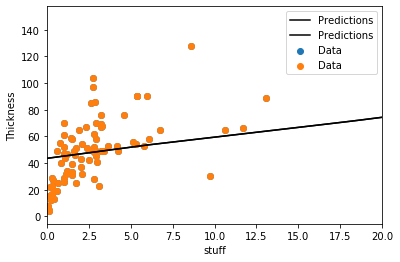

In [38]:

def plot_area(x, y):
    plt.scatter(train_features["AREA"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('stuff')
    plt.ylabel('Thickness')
    plt.xlim((0,20))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = dnn_area_model.predict(x)
plot_area(x,y)




plot_area(x, y)

In [39]:
dnn_test_results = {}
dnn_test_results['dnn_area_model'] = dnn_area_model.evaluate(
    test_features["AREA"], test_labels,
    verbose=0)

# Full model (not-quite-working)

In [40]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
dnn_full_model = build_and_compile_model(normalizer)
dnn_full_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [41]:
%%time
history_full = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.03 s, sys: 59.2 ms, total: 2.09 s
Wall time: 1.84 s


In [42]:
x = tf.linspace(0.0, 250, 251)
y = dnn_full_model.predict(x)

In [43]:
def plot_thickness(x, y):
    plt.scatter(train_features["LON"], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('bbb')
    plt.ylabel('Thickness')
    plt.xlim((0,180))
    plt.legend()
    
x = tf.linspace(0.0, 20, 101)
y = dnn_full_model.predict(x)
plot_elevation(x,y)




plot_thickness(x, y)

NameError: name 'plot_elevation' is not defined

In [ ]:
test_results["dnn_full_model"] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

test_results

In [ ]:
def plot_loss(history_full):
  plt.plot(history_full.history['loss'], label='loss')
  plt.plot(history_full.history['val_loss'], label='val_loss')
#   plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [THICKNESS]')
  plt.legend()
  plt.grid(True)
plot_loss(history_full)